In [135]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
!pip install webcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from webcolors import *
from matplotlib import pyplot as plt

In [239]:
image=cv2.imread("img.jpeg")

In [240]:
def extractSkin(image):
  img =  image.copy()
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

In [241]:
def removeBlack(estimator_labels, estimator_cluster):
  hasBlack = False
  occurance_counter = Counter(estimator_labels)
  compare = lambda x, y: Counter(x) == Counter(y)
  for x in occurance_counter.most_common(len(estimator_cluster)):
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    if compare(color , [0,0,0]) == True:
      del occurance_counter[x[0]]
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
  return (occurance_counter,estimator_cluster,hasBlack)
    

In [242]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return closest_name


In [243]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  occurance_counter = None
  
  colorInformation = []
  hasBlack =False
  
  if hasThresholding == True:
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black
  else:
    occurance_counter = Counter(estimator_labels)
  totalOccurance = sum(occurance_counter.values()) 
  for x in occurance_counter.most_common(len(estimator_cluster)):
    index = (int(x[0]))
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    
    color = estimator_cluster[index].tolist()
    color_percentage= (x[1]/totalOccurance)
    colorname = get_colour_name(color)
    colorInfo = {"cluster_index":index , "color": color, "color_name": colorname}
    
    colorInformation.append(colorInfo)      
  return colorInformation 

In [244]:
def extractDominantColor(image,number_of_colors=5,hasThresholding=False):
  if hasThresholding == True:
    number_of_colors +=1
  img = image.copy()
  
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  
  estimator.fit(img)
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  
  

In [245]:
def tone_code(color_info):
  return color_info[1]['color']

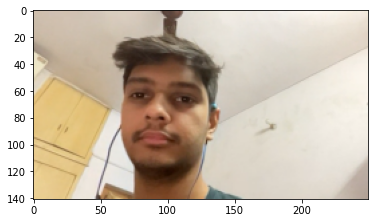

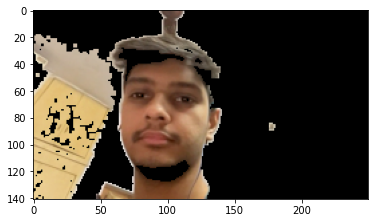

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [246]:
image = imutils.resize(image,width=250)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()
skin = extractSkin(image)
plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()
dominantColors = extractDominantColor(skin,hasThresholding=True)
# print("Color Information")  
# tone = tone_code(dominantColors)
tone = tone_code(dominantColors)

In [247]:
tone

[134.2531120331932, 91.97623538287377, 67.5846850245191]

In [248]:
tone = [round(x) for x in tone]

In [249]:
tone

[134, 92, 68]

In [250]:
# def rgb_to_hex(r, g, b):
#     return '#{:02x}{:02x}{:02x}'.format(r, g, b)

In [251]:
# hex_code = rgb_to_hex(tone[0], tone[1], tone[2])

In [254]:
def identify_skin_tone(tone):
    
    skin_tone_ranges = {
        'Very Light': [(232, 186, 144), (255, 218, 100)],
        'Light': [(210,161,140),(232, 186, 144)],
        'Fair': [(165,126,110), (210,161,140)],
        'Medium': [(120,92,60),(165,126,110)],
        'Light Brown': [(75,50,40),(120,92,80)],
        'Brown': [(45, 34, 30),(75,57,50)]
    }
    
    for skin_tone, rgb_range in skin_tone_ranges.items():
        if all(rgb_range[0][i] <= tone[i] <= rgb_range[1][i] for i in range(3)):
            return skin_tone
    
    return 'Unknown'


In [255]:
skin_tone = identify_skin_tone(tone)
print(f"The skin tone is: {skin_tone}")

The skin tone is: Medium
